In [52]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd   

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# 1. Data Preprocessing

## Importing dataset & Checking for missing data

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0            7.4              0.70         0.00             1.9      0.076  \
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates   
0                 11.0                  34.0   0.9978  3.51       0

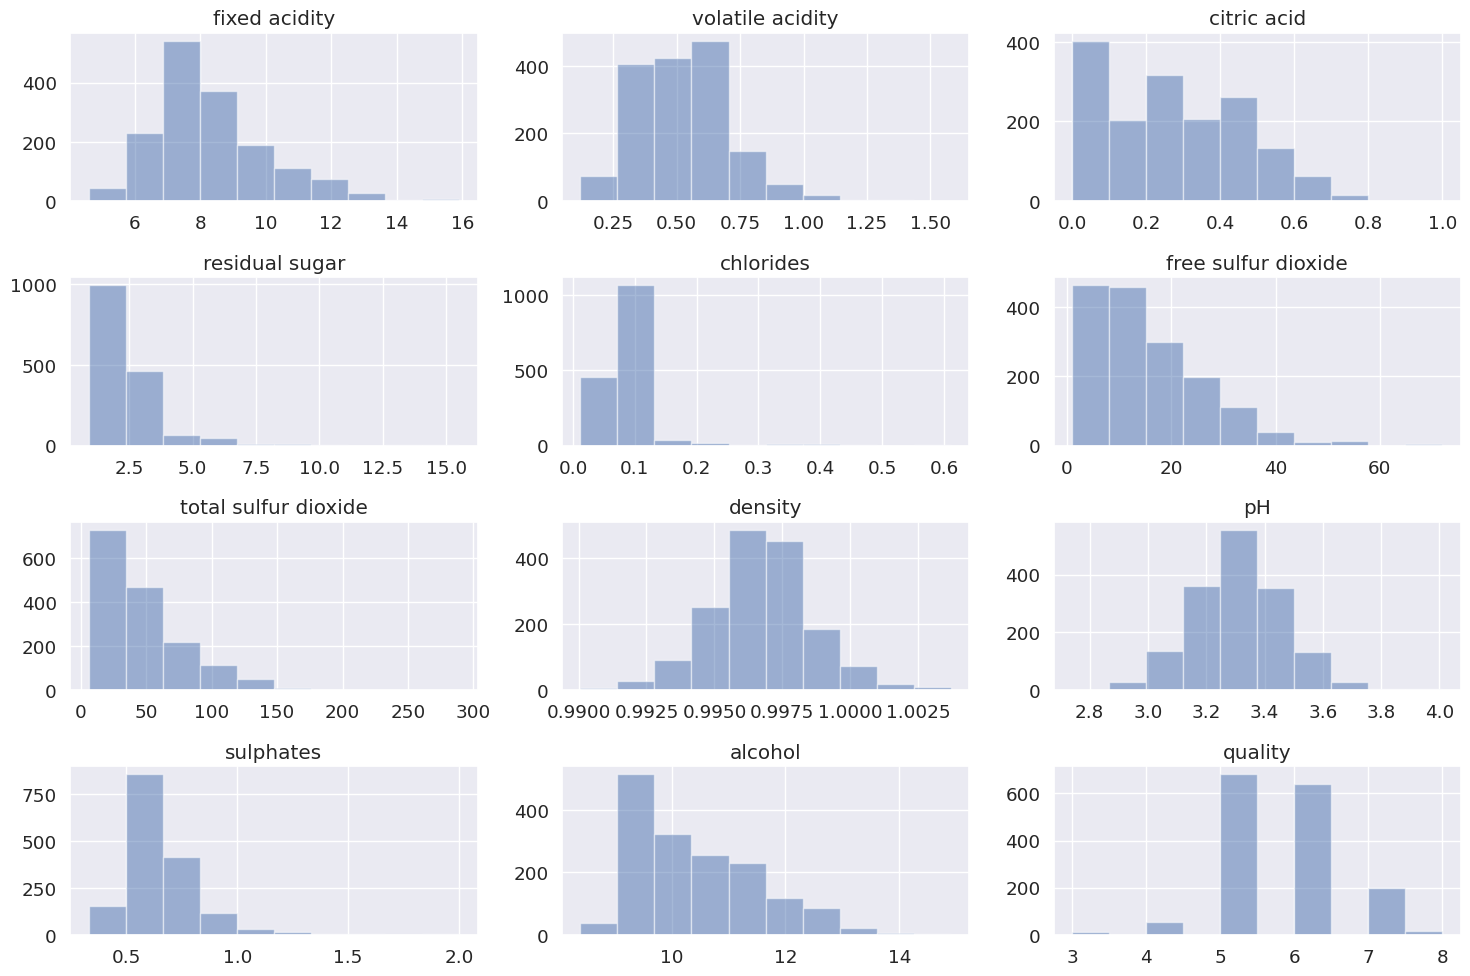


Checking for null values: 


Checking for null values after using fillna(): 



fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [53]:
headerList = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

wineData = pd.read_csv('winequality-red.csv', header = 0, names = headerList, sep=";")
print(wineData.head(10))

#Summarative functions
wineData.dtypes
wineData.describe()
wineData.info()

#Plotting histogram of each variable
wineData.hist(alpha=0.5, figsize=(15, 10))
plt.tight_layout()
plt.show()

for h in headerList:
  wineData[h] = pd.to_numeric(wineData[h], errors='coerce')

print("\nChecking for null values: \n")
wineData.isna().sum()
wineData = wineData.fillna(0)
print("\nChecking for null values after using fillna(): \n")
wineData.isna().sum()


### Our data is imbalanced as seen from the histogram. We will adapt multiple strategies to address the issue.

# 2. Exploratory Data Analysis

## 1. Principal Component Analysis (PCA)

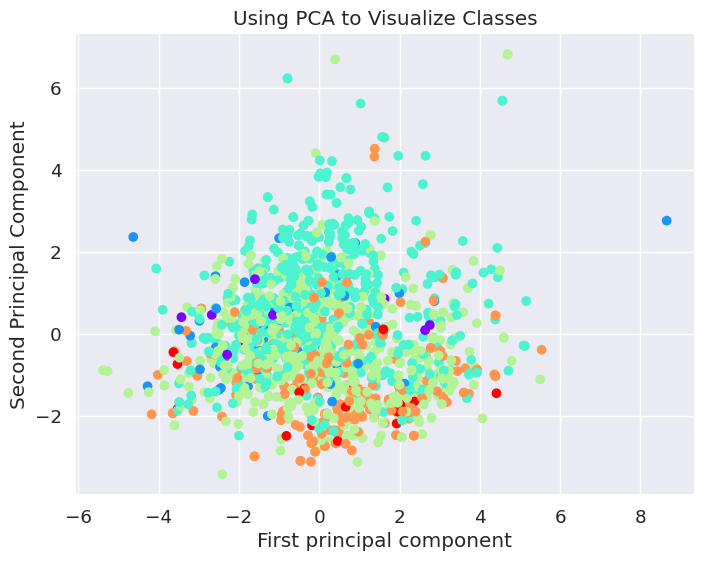

components:  [[ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
   0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323206]
 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
   0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]] 

explained variance:  [3.10107182 1.92711489] 

explained variance ratio:  [0.28173931 0.1750827 ]


In [54]:
#PCA
df_pca = wineData.copy()
X_pca = df_pca.loc[:, 'fixed acidity':'alcohol']
y_pca = df_pca['quality']

X_pca.tail()
X_pca = StandardScaler().fit_transform(X_pca)

#Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

X_pca.shape

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pca,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title("Using PCA to Visualize Classes")
plt.show()

print("components: ", pca.components_, "\n")
print("explained variance: ", pca.explained_variance_, "\n")
exp_var_rat = pca.explained_variance_ratio_
print("explained variance ratio: ", exp_var_rat)

## 2. Correlation Matrix

<Axes: >

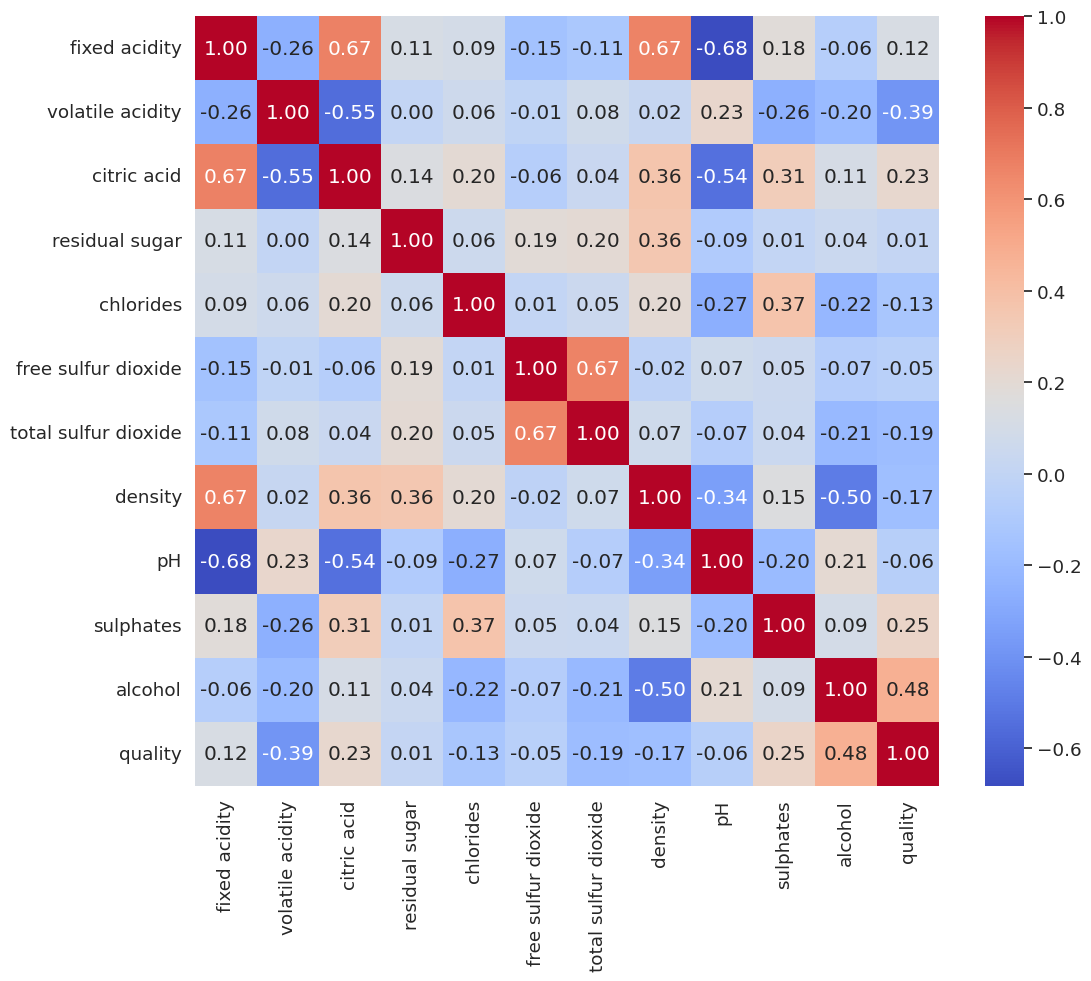

In [55]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(wineData.corr(),annot=True, cmap='coolwarm',fmt='.2f')

## 3. Univariate Selection

In [56]:
#Split data into training and test sets
X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']

# apply SelectKBest class to extract best features
bestFeatures = SelectKBest(score_func=chi2, k=11)
bestFeaturesFit = bestFeatures.fit(X,y)
dfscores = pd.DataFrame(bestFeaturesFit.scores_)
dfcolumns = pd.DataFrame(X.columns) 

# concatenate scores with predictor names
predScores = pd.concat([dfcolumns,dfscores],axis=1)
predScores.columns = ['Predictor','Score']
print(predScores.nlargest(11,'Score'))   

               Predictor        Score
6   total sulfur dioxide  2755.557984
5    free sulfur dioxide   161.936036
10               alcohol    46.429892
1       volatile acidity    15.580289
2            citric acid    13.025665
0          fixed acidity    11.260652
9              sulphates     4.558488
3         residual sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655
7                density     0.000230


## Dropping features from univariate selection

### We are dropping bottom four features as they have very low predictor scores and to save computation

In [57]:
#Drop the bottom four features (smallest score)
wineData = wineData.drop(['density'], axis=1)
wineData = wineData.drop(['pH'], axis=1)
wineData = wineData.drop(['chlorides'], axis=1)
wineData = wineData.drop(['residual sugar'], axis=1)
wineData

# wineData = wineData.drop('pH', 1)
# wineData = wineData.drop('chlorides', 1)
# wineData = wineData.drop('residual sugar', 1)

X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']

# Addressing Imbalance in Class

## First Strategy: Oversampling minority class

In [58]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

## Second Strategy: Undersampling majority class

In [59]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)

## Third Strategy: SMOTE

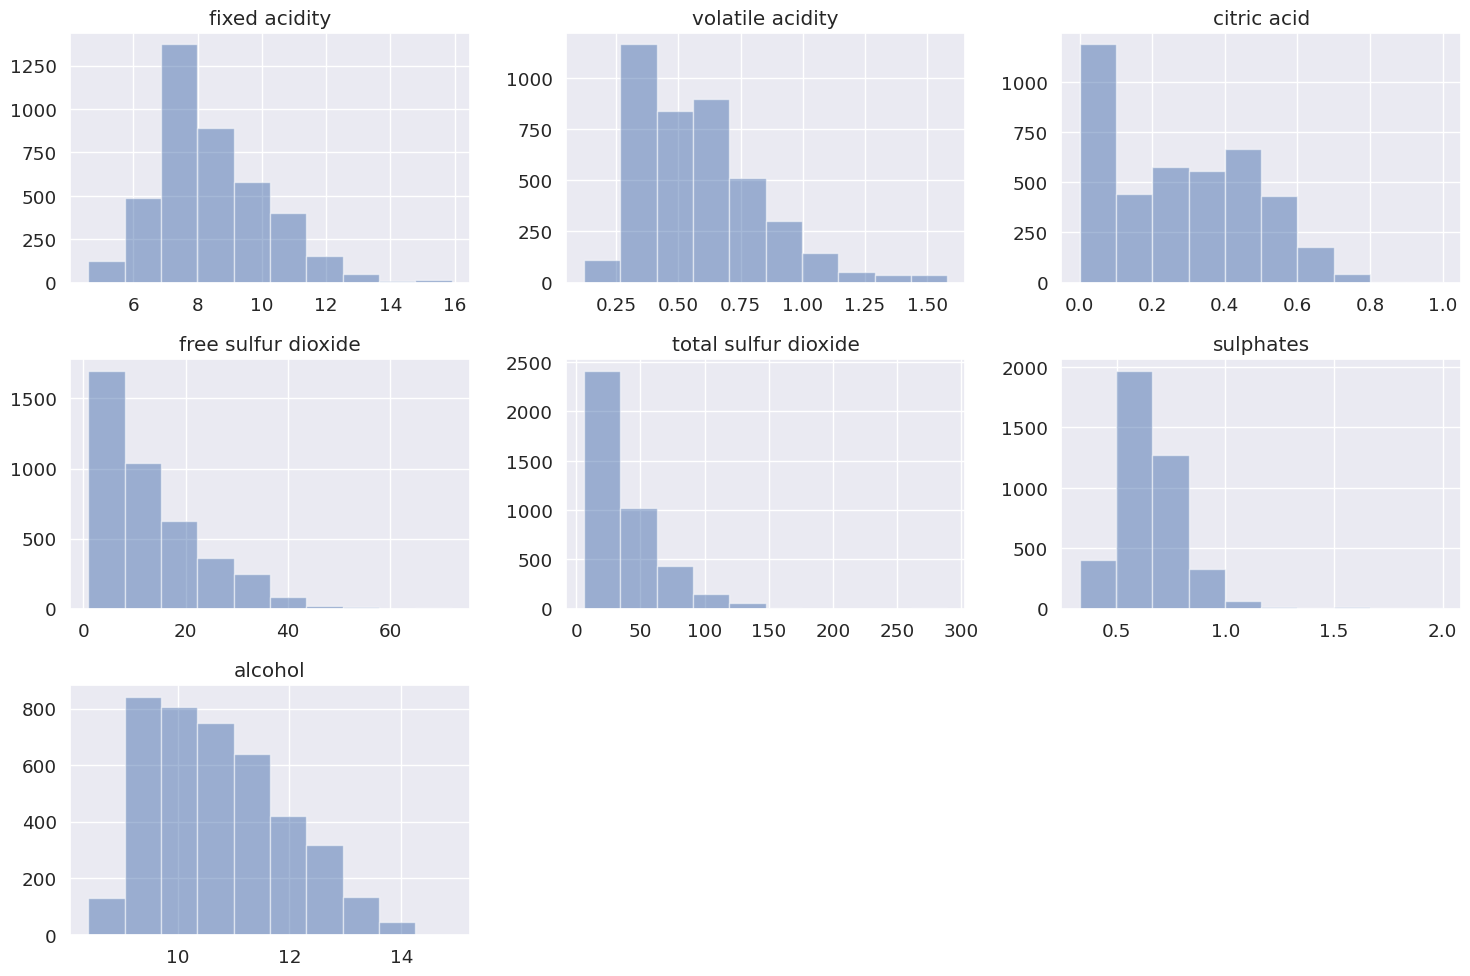

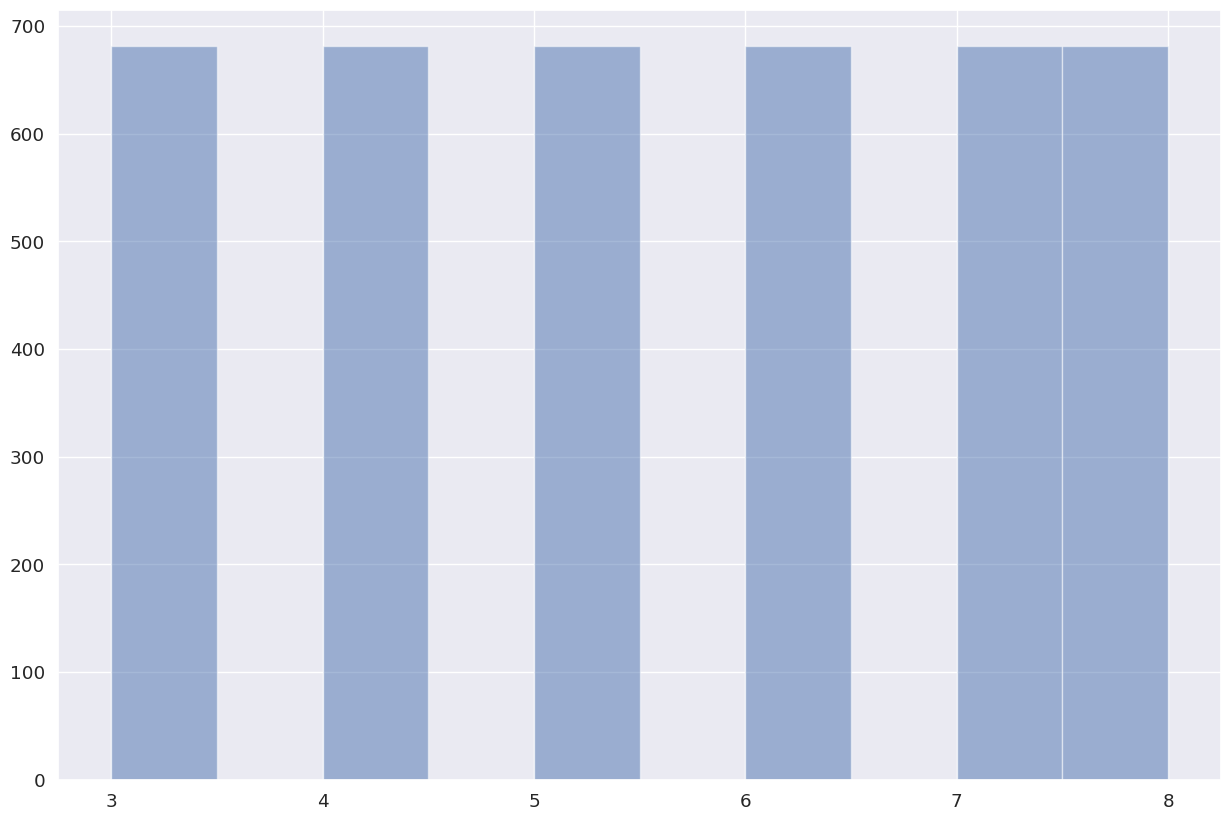

Before SMOTE :  Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
After SMOTE :  Counter({5: 681, 6: 681, 7: 681, 4: 681, 8: 681, 3: 681})


In [61]:
from imblearn.over_sampling import SMOTE
smoteOversample = SMOTE()
X_smote, y_smote = smoteOversample.fit_resample(X, y)

#Plotting histogram of each variable
X_smote.hist(alpha=0.5, figsize=(15, 10))

plt.tight_layout()
plt.show()

y_smote.hist(alpha=0.5, figsize=(15, 10))
plt.show()

from collections import Counter
print("Before SMOTE : ", Counter(y))
print("After SMOTE : ", Counter(y_smote))

# 3. Comparing Machine Learning Models

## Modeling - Final data preparations

In [ ]:
# 1. Regular Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=10) #split the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape
scaledData = StandardScaler()
X_train = scaledData.fit_transform(X_train)
X_test = scaledData.transform(X_test)

# 2. Oversampled Data
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size = .2, random_state=10) #split the data
X_over_train.shape, y_over_train.shape, X_over_test.shape, y_over_test.shape
scaledData = StandardScaler()
X_over_train = scaledData.fit_transform(X_over_train)
X_over_test = scaledData.transform(X_over_test)

# 3. Underrsampled Data
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size = .2, random_state=10) #split the data
X_over_train.shape, y_over_train.shape, X_over_test.shape, y_over_test.shape
scaledData = StandardScaler()
X_over_train = scaledData.fit_transform(X_over_train)
X_over_test = scaledData.transform(X_over_test)

## 1. Random Forest Classifier Modeling

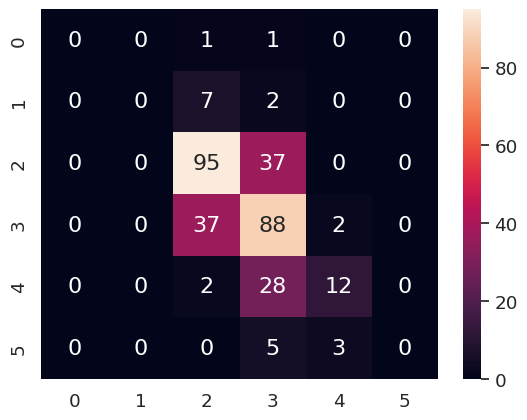

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.67      0.72      0.69       132
           6       0.55      0.69      0.61       127
           7       0.71      0.29      0.41        42
           8       0.00      0.00      0.00         8

    accuracy                           0.61       320
   macro avg       0.32      0.28      0.29       320
weighted avg       0.59      0.61      0.58       320



/home/bendjko/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bendjko/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bendjko/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
wineRF = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=417)
wineRF.fit(X_train, y_train)

y_pred = wineRF.predict(X_test)

#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

#Print classification report
clas = classification_report(y_test, y_pred)
print(clas)

## 2. Support Vector Machine Modeling

In [ ]:
wineSVM = SVC(kernel = 'rbf')
wineSVM.fit(X_train, y_train)
y_pred = wineSVM.predict(X_test)

#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

#Print classification report for rbf kernel
clas1 = classification_report(y_test, y_pred)
print("rbf kernel classification report: \n",clas1)

#Print classification report for sigmoid kernel
wineSVM = SVC(kernel = 'sigmoid')
wineSVM.fit(X_train, y_train)
y_pred = wineSVM.predict(X_test)
clas2 = classification_report(y_test, y_pred)
print("sigmoid kernel classification report: \n", clas2)

## 3. Artificial Neural Network

In [ ]:
wineMLP = MLPClassifier(activation='logistic', solver='sgd')
wineMLP.fit(X_train, y_train)
y_pred = wineMLP.predict(X_test)

#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

clas = classification_report(y_test, y_pred)
print(clas)

# 4. Hyperparameter Tuning

## 1. Random Forest Classifier

In [ ]:
#Create a default random forest object
wineRFC = RandomForestClassifier(random_state=417)

#create a list of parameters you want to tune
param_grid_RFC = { 
    'n_estimators': [100, 200, 400, 500, 700],
    'max_depth': [5,6,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2']
}

#fit the model using grid search
CV_rfc = GridSearchCV(estimator=wineRFC, param_grid=param_grid_RFC, cv= 10)
CV_rfc.fit(X_train, y_train)

#print the result of best hyperparameters
print(CV_rfc.best_params_)

## 2. Support Vector Machine

In [ ]:
wineSVM = SVC()
param_grid_svm = {
    'kernel': ['rbf','sigmoid','poly'], 
    'C': [1, 10, 100, 1000]
}

CV_svm = GridSearchCV(estimator=wineSVM, param_grid=param_grid_svm, cv= 10)
CV_svm.fit(X_train, y_train)

#print the result of best hyperparameters
print(CV_svm.best_params_)
           

## 3. Artificial Neural Network

In [ ]:
wineANN = MLPClassifier()
param_grid_ann = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 300, 400, 500],
}

CV_svm = GridSearchCV(estimator=wineANN, param_grid=param_grid_svm, cv= 10)
CV_svm.fit(X_train, y_train)

#print the result of best hyperparameters
print(CV_svm.best_params_)

# 5. Testing Final Models

## 1. Random Forest Classifier

## 2. Support Vector Machine

## 3. Artificial Neural Network

# 6. Testing best model on the test set
## 1. Random Forest Classifier

## 2. Support Vector Machine

## 3. Artificial Neural Network